In [66]:
import numpy as np


image_size = 28
no_of_different_labels = 2
image_pixels = image_size * image_size
data_path = r'C:\Users\amitb\PycharmProjects\IML\ex6\dataset\mldata'
train_data = np.loadtxt(data_path + r"\mnist_train.csv",
                        delimiter=",")
test_data = np.loadtxt(data_path + r"\mnist_test.csv",
                       delimiter=",")

fac = 0.99 / 255
all_train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
all_test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

all_train_labels = np.asfarray(train_data[:, :1])
all_test_labels = np.asfarray(test_data[:, :1])


class Digits:
    def __init__(self, d_1, d_2):
        binary_train_indices = np.logical_or((all_train_labels == d_1),
                                            (all_train_labels == d_2))
        binary_test_indices = np.logical_or((all_test_labels == d_1),
                                            (all_test_labels == d_2))

        binary_train_indices = binary_train_indices.reshape(
        binary_train_indices.shape[0])
        binary_test_indices = binary_test_indices.reshape(
            binary_test_indices.shape[0])

        x_train, y_train = all_train_imgs[binary_train_indices], \
                           all_train_labels[binary_train_indices]
        x_test, y_test = all_test_imgs[binary_test_indices], \
                         all_test_labels[binary_test_indices]

        y_train = y_train.reshape((len(y_train),))
        y_test = y_test.reshape((len(y_test),))
        y_train[y_train == d_1] = -1
        y_test[y_test == d_1] = -1
        y_train[y_train == d_2] = 1
        y_test[y_test == d_2] = 1
        self.x_train, self.y_train, self.x_test, self.y_test = \
            x_train, y_train, x_test, y_test


In [67]:
from matplotlib import pyplot as plt


BATCHES = [5, 50, 100]
ETAS = [1, 0.1, 10]
REG_PARAM = 0
ITERS = 150


def get_subgradient(w, reg_param, data, labels):
    sample = data[0]
    sample_length = len(sample)
    m = len(data)
    only_w = w[: len(w) - 1]
    b = w[-1]
    sm = np.zeros(sample_length+1)
    for i in range(m):
        y_i = labels[i]
        x_i = data[i]
        extended_x_i = np.append(data[i], 1)
        curr = y_i * extended_x_i
        if y_i * (only_w @ x_i + b) < 1:
            sm += curr
    extended_w = np.append(only_w, 0)
    return reg_param * extended_w - 1/m * sm



def gd(data, labels, iters, eta, w, reg_param):
    """
    The sub gradient descent algorithm
    :param data: An n by d numpy array, where n is the amount of samples and
    d is the dimension of each sample
    :param labels: An n by 1 numpy array with the labels of each sample
    :param iters: An integer that will define the amount of iterations
    :param eta: A positive number that will define the learning rate
    :param w: A d+1 by 1 numpy array where d is the dimension of each sample
    i.e. the parameters of the classifier where the last element is the bias
    :param reg_param: The regularization parameter in the sub-gradient
    :return: A d+1 by 1 numpy array which contains the output of the sub
    gradient descent algorithm over "iters" iterations and array of losses,
    one for each iteration
    """
    vecs = []
    for iter in range(iters):
        w += -eta * get_subgradient(w, reg_param, data, labels)
        vecs.append(w.copy())
    return 1/iters * np.sum(vecs, axis=0), vecs


def sgd(data, labels, iters, eta, w, batch):
    """
    The stochastic gradient descent algorithm
    :param data: An n by d numpy array, where n is the amount of samples and
    d is the dimension of each sample
    :param labels: An n by 1 numpy array with the labels of each sample
    :param iters: An integer that will define the amount of iterations
    :param eta: A positive number that will define the learning rate
    :param w: A d+1 by 1 numpy array where d is the dimension of each sample
    i.e. the parameters of the classifier where the last element is the bias
    :param batch: The amount of samples that the algorithm would draw and
    use at each iteration
    :return: A d+1 by 1 numpy array which contains the output of the
    sub-gradient descent algorithm over "iters" iterations and array of losses,
    one for each iteration
    """
    vecs = []
    sets = []
    for iter in range(iters):
        samples_indices = np.random.choice(range(len(data)), batch)
        samples = np.take(data, samples_indices, axis=0)
        samples_labels = np.take(labels, samples_indices, axis=0)
        v_t = get_subgradient(w, 0, samples, samples_labels)
        # z_t_index = np.random.choice(samples_indices)
        # z_t = data[z_t_index]
        # y_t = labels[z_t_index]
        # z_t_extended = np.append(z_t, 1)
        # v_t = -y_t * z_t_extended
        w -= eta * v_t
        vecs.append(w.copy())
        sets.append(samples_indices)
    return 1/iters * np.sum(vecs, axis=0), vecs, sets


def get_errors(vecs, data, labels):
    errors = []
    for vec in vecs:
        errors.append(test_error(vec, data, labels))
    return errors


def get_sgd_train_errors(vecs, sets, data, labels):
    errors = []
    for i in range(len(vecs)):
        samples = np.take(data, sets[i], axis=0)
        samples_labels = np.take(labels, sets[i], axis=0)
        errors.append(test_error(vecs[i], samples, samples_labels))
    return errors


def get_hypothesis(w):
    def h_w(x):
        return np.sign(w[:-1] @ x + w[-1])
    return h_w


def test_error(w, test_data, test_labels):
    """
    Returns a scalar with the respective 0-1 loss for the hypothesis
    :param w: a d+1 by 1 numpy array where h_w(x) = sign(<w[:-1], x> + w[-1])
    :param test_data: An n by d numpy array with n samples
    :param test_labels: An n by 1 numpy array with the labels of the samples
    :return: A scalar with the respective 0-1 loss for the hypothesis
    """
    h_w = get_hypothesis(w)
    test_predictions = []
    for sample in test_data:
        test_predictions.append(h_w(sample))
    result = test_labels - test_predictions
    samples_amount = len(result)
    non_zeros_amount = np.count_nonzero(result)
    # zeros_amount = samples_amount - non_zeros_amount
    return non_zeros_amount / samples_amount







In [68]:
def plot_errors_old(data, labels, iters, eta, w, reg_param, set_str):
    gd_w, gd_errors = gd(data, labels, iters, eta, w, reg_param)
    iters_range = range(ITERS)
    plt.plot(iters_range, gd_errors, label='GD')
    sgd_w_lst = []
    for batch in BATCHES:
        sgd_w, sgd_errors = sgd(data, labels, iters, eta, w, batch)
        sgd_w_lst.append(sgd_w)
        plt.plot(iters_range, sgd_errors, label='SGD, batch: {}'.format(batch))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses of the GD and SGD algorithms\non the {} '
              'set\nper iteration, for {} '
              'iterations'.format(set_str, ITERS))
    plt.show()
    return gd_w, sgd_w_lst


def plot_errors_helper(iters, gd_errors, sgd_errors_lst, set_str, eta,
                       reg_param):
    iters_lst = range(iters)
    plt.plot(iters_lst, gd_errors, label='GD')
    for i in range(len(BATCHES)):
        plt.plot(iters_lst, sgd_errors_lst[i], label='SGD {}'.format
        (BATCHES[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses of the GD and SGD algorithms\non the {} '
              'set\nper iteration, for {} '
              'iterations\nwith learning rate of {}\nand reguralization '
              'parameter of {}'.format(set_str, iters, eta, reg_param))
    plt.show()


def plot_errors(train_samples, train_labels, test_samples, test_labels, iters,
                eta, w, reg_param):
    w_gd, vecs_gd = gd(train_samples, train_labels, iters, eta, w, reg_param)
    gd_train_errors = get_errors(vecs_gd, train_samples, train_labels)
    gd_test_errors = get_errors(vecs_gd, test_samples, test_labels)
    sgd_train_errors_lst = []
    sgd_test_errors_lst = []
    for batch in BATCHES:
        w_sgd, vecs_sgd, sets_sgd = sgd(train_samples, train_labels, iters, eta,
                                     w, batch)
        # sgd_train_errors_lst.append(get_sgd_train_errors(vecs_sgd, sets_sgd,
    #                                            train_samples, train_labels))
        sgd_train_errors_lst.append(get_errors(vecs_sgd, train_samples,
                                               train_labels))
        sgd_test_errors_lst.append(get_errors(vecs_sgd, test_samples,
                                               test_labels))
    plot_errors_helper(iters, gd_train_errors, sgd_train_errors_lst,
                       'training', eta, reg_param)
    plot_errors_helper(iters, gd_test_errors, sgd_test_errors_lst, 'test',
                       eta, reg_param)


    #gd_w, sgd_w_lst = #
    # plot_errors_helper(train_samples, train_labels, iters,
    #                              eta, w, reg_param, 'training')
    # plot_errors_helper(test_samples, test_labels, iters,
    #                    eta, w, reg_param, 'test')
    # gd_test_error = test_error(gd_w, test_samples, test_labels)
    # sgd_test_errors = []
    # for sgd_w in sgd_w_lst:
    #     sgd_test_errors.append(test_error(sgd_w, test_samples, test_labels))
    # plt.scatter('GD', gd_test_error)
    # for i in range(len(sgd_test_errors)):
    #     plt.scatter('SGD {}'.format(BATCHES[i]), sgd_test_errors[i])
    # plt.ylabel('Loss')
    # plt.title('Loss of the GD and SGD algorithms\non the test set\nwhere '
    #           'the SGD '
    #           'algorithm was tested by different sizes of batches\nspecified '
    #           'in the X-axis')
    # plt.show()




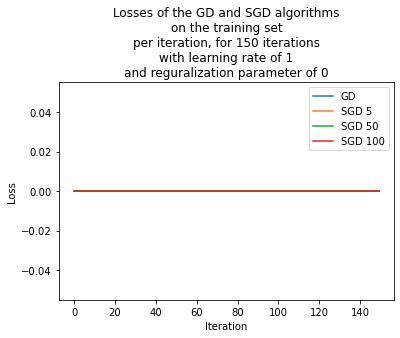

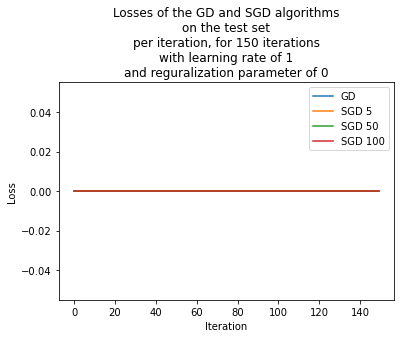

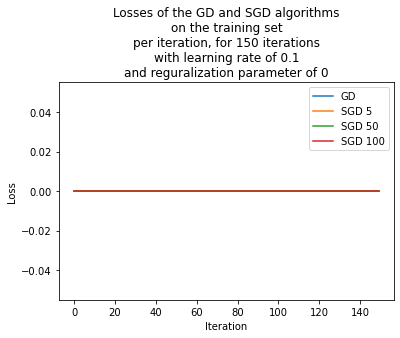

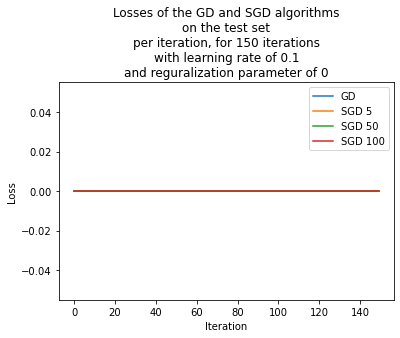

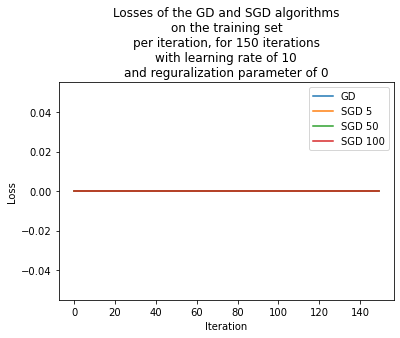

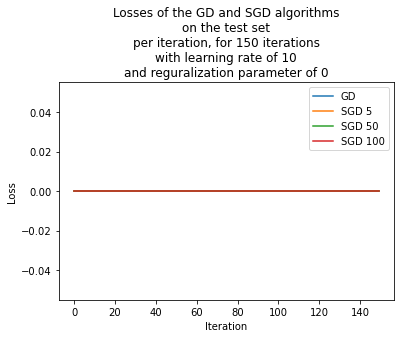

In [69]:
def classify_digits(d_1 ,d_2):
    sets = Digits(d_1, d_2)
    sample = sets.x_train[0]
    w_length = len(sample) + 1
    zero_w = np.zeros(w_length)
    # random_w = np.random.rand(w_length)
    # eta = np.random.rand(1)[0]
    # reg_param = np.random.randint(0, 10, 1)[0] + np.random.rand(1)[0]
    # random_reg_param = np.random.randint(0, 10, 1)[0] + np.random.rand(1)[0]
    for eta in ETAS:
        plot_errors(sets.x_train, sets.y_train, sets.x_test, sets.y_test,
                    ITERS, eta, zero_w, REG_PARAM)


classify_digits(0 ,1)
# classify_digits(3 ,5)